Dataset:- https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

# STEP 1: IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score, recall_score)

# STEP 2: LOAD DATASET

In [ ]:
df = pd.read_csv("spam.csv", encoding='latin-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print(f"Dataset loaded: {df.shape}")
print(f"Total messages: {len(df)}")

Dataset loaded: (5572, 2)
Total messages: 5572


# STEP 3: BASIC EDA

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
df.isnull().sum()

,0
label,0
message,0


In [ ]:
# Target distribution
print("--- Target Distribution ---")

print(df['label'].value_counts())
print(f"\nSpam Percentage: {(df['label']=='spam').sum() / len(df) * 100:.2f}%")

--- Target Distribution ---
label
ham     4825
spam     747
Name: count, dtype: int64

Spam Percentage: 13.41%


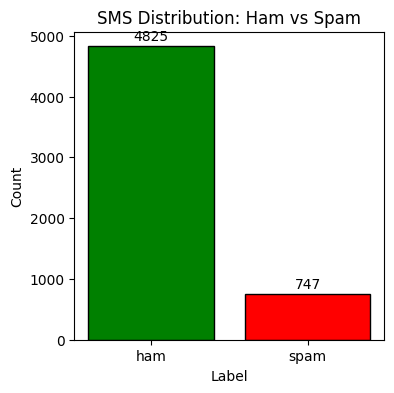

In [ ]:
# Visualize target distribution
plt.figure(figsize=(4, 4))

label_counts = df['label'].value_counts()
colors = ['green', 'red']

plt.bar(label_counts.index, label_counts.values, color=colors, edgecolor='black')

plt.title('SMS Distribution: Ham vs Spam')
plt.ylabel('Count')
plt.xlabel('Label')

for i, v in enumerate(label_counts.values):
    plt.text(i, v + 100, str(v), ha='center')

plt.show()

In [ ]:
print(f"\n⚠️ CLASS IMBALANCE DETECTED!")
print(f"   Ham: {label_counts['ham']} ({label_counts['ham']/len(df)*100:.1f}%)")
print(f"   Spam: {label_counts['spam']} ({label_counts['spam']/len(df)*100:.1f}%)")
print(f"   Imbalance Ratio: {label_counts['ham']/label_counts['spam']:.2f}:1")


⚠️ CLASS IMBALANCE DETECTED!
   Ham: 4825 (86.6%)
   Spam: 747 (13.4%)
   Imbalance Ratio: 6.46:1


# STEP 4: TEXT EXPLORATION

In [ ]:
# Add message length feature
df['message_length'] = df['message'].apply(len)

print("--- Message Length Statistics ---")
print(df.groupby('label')['message_length'].describe())

--- Message Length Statistics ---
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0



--- Message Length Statistics ---
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


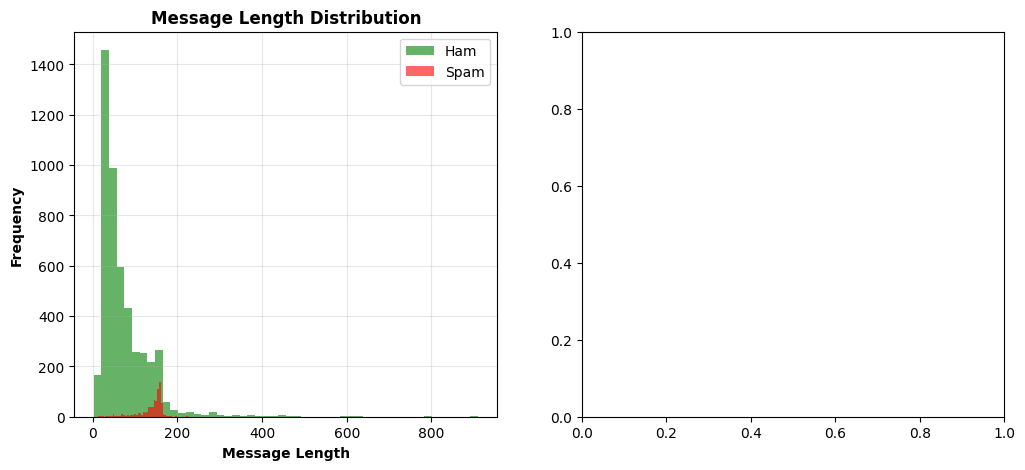

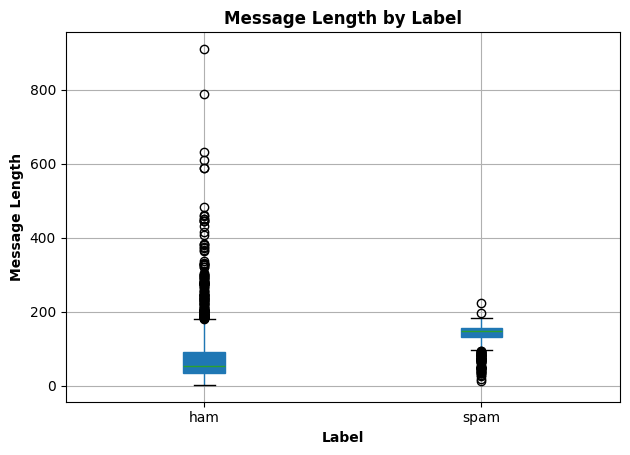


💡 Key Observation:
   • Spam messages tend to be longer (more promotional text)
   • Average Ham length: 71.0 chars
   • Average Spam length: 138.9 chars

--- Sample Ham Messages ---
   • Go until jurong point, crazy.. Available only in bugis n great world la e buffet...
   • Ok lar... Joking wif u oni......
   • U dun say so early hor... U c already then say......

--- Sample Spam Messages ---
   • Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
   • FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some...
   • WINNER!! As a valued network customer you have been selected to receivea å£900 p...


In [ ]:
# Add message length feature
df['message_length'] = df['message'].apply(len)

print("\n--- Message Length Statistics ---")
print(df.groupby('label')['message_length'].describe())

# Visualize message length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[df['label']=='ham']['message_length'].hist(bins=50, alpha=0.6,
                                                label='Ham', color='green')
df[df['label']=='spam']['message_length'].hist(bins=50, alpha=0.6,
                                                 label='Spam', color='red')
plt.xlabel('Message Length', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Message Length Distribution', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
df.boxplot(column='message_length', by='label', patch_artist=True)
plt.xlabel('Label', fontweight='bold')
plt.ylabel('Message Length', fontweight='bold')
plt.title('Message Length by Label', fontweight='bold')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("   • Spam messages tend to be longer (more promotional text)")
print(f"   • Average Ham length: {df[df['label']=='ham']['message_length'].mean():.1f} chars")
print(f"   • Average Spam length: {df[df['label']=='spam']['message_length'].mean():.1f} chars")

# Show sample messages
print("\n--- Sample Ham Messages ---")
for msg in df[df['label']=='ham']['message'].head(3):
    print(f"   • {msg[:80]}...")

print("\n--- Sample Spam Messages ---")
for msg in df[df['label']=='spam']['message'].head(3):
    print(f"   • {msg[:80]}...")


# STEP 5: TEXT PREPROCESSING & FEATURE EXTRACTION

In [ ]:
# Convert labels to binary
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

In [ ]:
# Split data
X = df['message']
y = df['label_encoded']

print(f"Total samples: {len(X)}")
print(f"Features: Text messages")
print(f"Target: 0=Ham, 1=Spam")

Total samples: 5572
Features: Text messages
Target: 0=Ham, 1=Spam


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    )

In [ ]:
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Training samples: 4457 (80.0%)
Testing samples: 1115 (20.0%)


In [ ]:
# Convert text to numerical features using TF-IDF
print("\n--- Converting Text to TF-IDF Features ---")
print("💡 TF-IDF: Term Frequency-Inverse Document Frequency")
print("   • Assigns higher weight to rare, important words")
print("   • Reduces weight of common words (like 'the', 'is')")

vectorizer = TfidfVectorizer(
    max_features=3000,  # Keep top 3000 words
    stop_words='english',  # Remove common words
    lowercase=True,
    ngram_range=(1, 2)  # Use 1-word and 2-word combinations
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nTF-IDF features created: {X_train_tfidf.shape[1]} features")
print(f"Training matrix shape: {X_train_tfidf.shape}")
print(f"Testing matrix shape: {X_test_tfidf.shape}")



--- Converting Text to TF-IDF Features ---
💡 TF-IDF: Term Frequency-Inverse Document Frequency
   • Assigns higher weight to rare, important words
   • Reduces weight of common words (like 'the', 'is')

TF-IDF features created: 3000 features
Training matrix shape: (4457, 3000)
Testing matrix shape: (1115, 3000)


In [ ]:
# Show top words
feature_names = vectorizer.get_feature_names_out()
print(f"\n--- Sample Features (Top 20 Words) ---")
print(feature_names[:20])


--- Sample Features (Top 20 Words) ---
['00' '00 sub' '000' '000 bonus' '000 cash' '02' '02 06' '03' '03 2nd'
 '04' '05' '06' '06 03' '0800' '0800 542' '08000839402'
 '08000839402 call2optout' '08000930705' '08000930705 delivery'
 '08001950382']


# STEP 6: TRAIN DEFAULT MODEL

In [ ]:
print("Training Multinomial Naive Bayes...")
print("💡 Multinomial NB: Best for text classification with word counts")

model_default = MultinomialNB()
model_default.fit(X_train_tfidf, y_train)

Training Multinomial Naive Bayes...
💡 Multinomial NB: Best for text classification with word counts


MultinomialNB()

In [ ]:
# Predictions
y_pred_default = model_default.predict(X_test_tfidf)
y_pred_proba_default = model_default.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
# Evaluation
acc_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)

print("--- Default Model Performance ---")
print(f"Accuracy: {acc_default:.4f} ({acc_default*100:.1f}%)")
print(f"Precision: {precision_default:.4f}")
print(f"Recall: {recall_default:.4f}")
print(f"F1-Score: {f1_default:.4f}")

--- Default Model Performance ---
Accuracy: 0.9758 (97.6%)
Precision: 0.9919
Recall: 0.8255
F1-Score: 0.9011


In [ ]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_default,
                            target_names=['Ham', 'Spam']))

--- Classification Report ---
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       0.99      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115




--- Confusion Matrix ---
[[965   1]
 [ 26 123]]


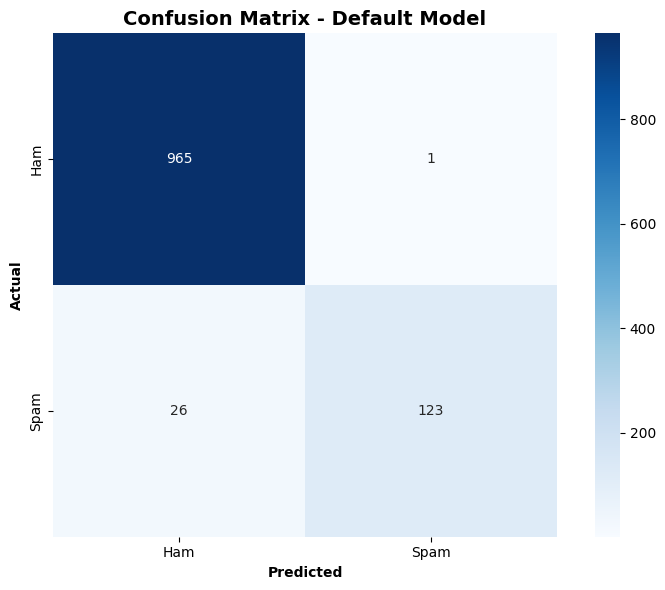

In [ ]:
# Confusion Matrix
cm_default = confusion_matrix(y_test, y_pred_default)
print("\n--- Confusion Matrix ---")
print(cm_default)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Ham', 'Spam'],
           yticklabels=['Ham', 'Spam'],
           cbar=True, square=True)
plt.title('Confusion Matrix - Default Model', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# STEP 7: CROSS-VALIDATION

In [ ]:
cv_scores = cross_val_score(model_default, X_train_tfidf, y_train,
                             cv=5, scoring='accuracy', n_jobs=-1)

print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\n--- Comparison ---")
print(f"CV Accuracy (5-fold): {cv_scores.mean():.4f}")
print(f"Test Accuracy:        {acc_default:.4f}")
print(f"Difference:           {abs(cv_scores.mean() - acc_default):.4f}")

if abs(cv_scores.mean() - acc_default) < 0.02:
    print("\n✅ Model generalizes well!")
else:
    print("\n⚠️ Some gap - but acceptable for text data")

CV Accuracy Scores: [0.98206278 0.97869955 0.98316498 0.97194164 0.97643098]
Mean CV Accuracy: 0.9785 (+/- 0.0040)

--- Comparison ---
CV Accuracy (5-fold): 0.9785
Test Accuracy:        0.9758
Difference:           0.0027

✅ Model generalizes well!


# STEP 8: HYPERPARAMETER TUNING

In [ ]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],  # Smoothing parameter
    'fit_prior': [True, False]
}

print("Running GridSearchCV...")
print("Expected time: 10-20 seconds...")

grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='f1',  # Optimize for F1 (good for imbalanced data)
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print("\n--- Best Hyperparameters Found ---")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

Running GridSearchCV...
Expected time: 10-20 seconds...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Best Hyperparameters Found ---
alpha: 0.1
fit_prior: True
Best CV F1-Score: 0.9447


In [ ]:
# Predict with tuned model
y_pred_tuned = grid_search.best_estimator_.predict(X_test_tfidf)

In [ ]:
acc_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("--- Tuned Model Performance ---")
print(f"Accuracy: {acc_tuned:.4f} ({acc_tuned*100:.1f}%)")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")

print(f"\nImprovement: {(acc_tuned - acc_default)*100:+.2f}%")

--- Tuned Model Performance ---
Accuracy: 0.9821 (98.2%)
Precision: 0.9778
Recall: 0.8859
F1-Score: 0.9296

Improvement: +0.63%


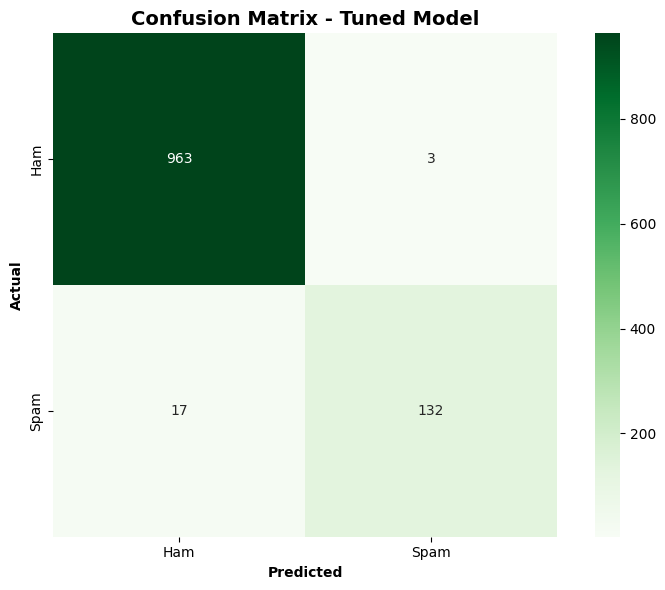

In [ ]:
# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Ham', 'Spam'],
           yticklabels=['Ham', 'Spam'],
           cbar=True, square=True)
plt.title('Confusion Matrix - Tuned Model', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# STEP 9: TOP SPAM WORDS (FEATURE ANALYSIS)


In [ ]:
# Get feature log probabilities
feature_log_prob = grid_search.best_estimator_.feature_log_prob_
feature_names = vectorizer.get_feature_names_out()

# Top spam words (class 1)
spam_log_prob = feature_log_prob[1]
top_spam_indices = spam_log_prob.argsort()[-20:][::-1]

print("\n--- Top 20 Spam Indicator Words ---")
for i, idx in enumerate(top_spam_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} (log_prob: {spam_log_prob[idx]:.4f})")

# Top ham words (class 0)
ham_log_prob = feature_log_prob[0]
top_ham_indices = ham_log_prob.argsort()[-20:][::-1]

print("\n--- Top 20 Ham Indicator Words ---")
for i, idx in enumerate(top_ham_indices, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} (log_prob: {ham_log_prob[idx]:.4f})")



--- Top 20 Spam Indicator Words ---
 1. free                 (log_prob: -4.5880)
 2. txt                  (log_prob: -4.8488)
 3. stop                 (log_prob: -5.0288)
 4. text                 (log_prob: -5.0653)
 5. claim                (log_prob: -5.0824)
 6. mobile               (log_prob: -5.1228)
 7. reply                (log_prob: -5.1674)
 8. ur                   (log_prob: -5.2117)
 9. www                  (log_prob: -5.2271)
10. uk                   (log_prob: -5.2740)
11. new                  (log_prob: -5.2868)
12. prize                (log_prob: -5.3142)
13. service              (log_prob: -5.4067)
14. cash                 (log_prob: -5.4465)
15. won                  (log_prob: -5.4620)
16. 150p                 (log_prob: -5.4761)
17. urgent               (log_prob: -5.5571)
18. com                  (log_prob: -5.5797)
19. win                  (log_prob: -5.5815)
20. 18                   (log_prob: -5.6793)

--- Top 20 Ham Indicator Words ---
 1. ok                   (l

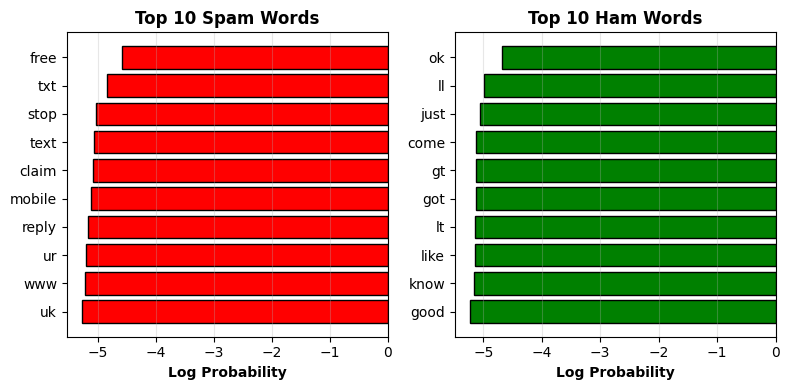

In [ ]:
# Visualize top spam words
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
top_spam_words = [feature_names[i] for i in top_spam_indices[:10]]
top_spam_probs = [spam_log_prob[i] for i in top_spam_indices[:10]]
plt.barh(top_spam_words, top_spam_probs, color='red', edgecolor='black')
plt.xlabel('Log Probability', fontweight='bold')
plt.title('Top 10 Spam Words', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.subplot(1, 2, 2)
top_ham_words = [feature_names[i] for i in top_ham_indices[:10]]
top_ham_probs = [ham_log_prob[i] for i in top_ham_indices[:10]]
plt.barh(top_ham_words, top_ham_probs, color='green', edgecolor='black')
plt.xlabel('Log Probability', fontweight='bold')
plt.title('Top 10 Ham Words', fontweight='bold', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


# STEP 10: TEST ON NEW MESSAGES

In [ ]:
# Sample test messages
test_messages = [
    "Hey, are we still meeting for lunch today?",
    "CONGRATULATIONS! You've won a FREE iPhone! Click here to claim: bit.ly/win123",
    "Can you pick up milk on your way home?",
    "URGENT! Your account has been compromised. Call 1800-BANK-NOW immediately!",
    "Thanks for the help yesterday, really appreciate it!",
    "Win $$$ CASH PRIZE $$$ Text WIN to 12345 NOW!!!",
]

print("\n--- Predicting New Messages ---\n")

# Vectorize test messages
test_tfidf = vectorizer.transform(test_messages)

# Predict
predictions = grid_search.best_estimator_.predict(test_tfidf)
probabilities = grid_search.best_estimator_.predict_proba(test_tfidf)

for i, (msg, pred, prob) in enumerate(zip(test_messages, predictions, probabilities), 1):
    label = 'SPAM 🚨' if pred == 1 else 'HAM ✅'
    confidence = prob[pred] * 100

    print(f"{i}. Message: {msg[:70]}")
    print(f"   Prediction: {label} (Confidence: {confidence:.1f}%)\n")


--- Predicting New Messages ---

1. Message: Hey, are we still meeting for lunch today?
   Prediction: HAM ✅ (Confidence: 99.9%)

2. Message: CONGRATULATIONS! You've won a FREE iPhone! Click here to claim: bit.ly
   Prediction: SPAM 🚨 (Confidence: 94.6%)

3. Message: Can you pick up milk on your way home?
   Prediction: HAM ✅ (Confidence: 99.9%)

4. Message: URGENT! Your account has been compromised. Call 1800-BANK-NOW immediat
   Prediction: SPAM 🚨 (Confidence: 66.8%)

5. Message: Thanks for the help yesterday, really appreciate it!
   Prediction: HAM ✅ (Confidence: 99.6%)

6. Message: Win $$$ CASH PRIZE $$$ Text WIN to 12345 NOW!!!
   Prediction: SPAM 🚨 (Confidence: 97.4%)



# STEP 11: MODEL COMPARISON

In [ ]:
comparison = pd.DataFrame({
    'Model': ['Default', 'Tuned'],
    'Accuracy': [acc_default, acc_tuned],
    'Precision': [precision_default, precision_tuned],
    'Recall': [recall_default, recall_tuned],
    'F1-Score': [f1_default, f1_tuned]
})

print("\n")
print(comparison.to_string(index=False))

best_idx = comparison['F1-Score'].idxmax()
print(f"\nBest Model: {comparison.loc[best_idx, 'Model']}")
print(f"Best F1-Score: {comparison.loc[best_idx, 'F1-Score']:.4f}")




  Model  Accuracy  Precision   Recall  F1-Score
Default  0.975785   0.991935 0.825503  0.901099
  Tuned  0.982063   0.977778 0.885906  0.929577

Best Model: Tuned
Best F1-Score: 0.9296
